In [1]:
%cd ..
%cd ..
# move to the root directory of the git

/workspace/FLOOD_group2/models
/workspace/FLOOD_group2


In [2]:
import importlib
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

# import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import *
from post_processing.cool_animation import plot_animation
from post_processing.plots import plot_losses

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_4batch_16hidden_3kernel_augmentation.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# # From FAT application
# fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# # specify which entry of the dataset to plot
# numb = 0
# inputs = train_dataset[numb][0][0]

# axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
# axs[0].set_title('DEM')

# axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
# axs[1].set_title('Slope X')

# axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
# axs[2].set_title('Slope Y')

# non_zero_indices = torch.nonzero(inputs[3].cpu())
# non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
# axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
# axs[3].set_title('Breach Location')
# axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
#                 clip_on = False, clip_box = plt.gca().transData)
# plt.show()

In [8]:
def augmentation(train_dataset, range_t, p_hflip=0.5, p_vflip=0.5, full=True):
    '''
    Function for implementing data augmentation of inputs (DEM, X- and Y-Slope,
    Water Depth, and Discharge).

    Input: train_dataset = torch tensor, dataset with input variables
           p_hflip, p_vflip = float, probability of horizontal and vertical flipping
                              default = 0.5 for both
           angles = angle degrees for dataset rotation, fixed at 0°, 90°, 180°, 270°
    Output:
    '''
    # Define the transformation pipeline with horizontal and vertical flip
    transformation_pipeline = transforms.Compose([
        transforms.RandomHorizontalFlip(p=p_hflip),
        transforms.RandomVerticalFlip(p=p_vflip)])

    # Apply the transformation to each sample in the original dataset
    transformed_samples = [transformation_pipeline(sample) for sample in train_dataset]

    # Unpack the tuples and create a new dataset with the transformed samples
    transformed_tensors = [torch.stack(sample) for sample in zip(*transformed_samples)]
    transformed_dataset = torch.utils.data.TensorDataset(*transformed_tensors)

    # Concatenate the original dataset and the transformed dataset
    full_dataset = torch.utils.data.ConcatDataset([train_dataset, transformed_dataset])

    # Print the shapes of datasets
    # print(f"Shape of train_dataset: {np.shape(train_dataset)}")
    # print(f"Shape of transformed_dataset: {np.shape(transformed_dataset)}")
    # print(f"Shape of full_dataset: {np.shape(full_dataset)}")

    return full_dataset if full else transformed_dataset

In [9]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_dataset)

normalized_train_dataset = normalize_dataset(train_dataset, scaler_x, scaler_wd, scaler_q, train_val)

In [10]:
transformed_dataset = augmentation(normalized_train_dataset, range_t=len(normalized_train_dataset), p_hflip=0.5, p_vflip=0.5, full=True)

In [11]:
# np.shape(transformed_dataset)

In [12]:
# concat = torch.utils.data.ConcatDataset([normalized_train_dataset, transformed_dataset], collate_fn=collate_fn, shuffle=True)

In [13]:
# len(concat)

In [14]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_set, val_set = random_split(transformed_dataset, [train_size, val_size])

In [17]:
# Model
model = ConvLSTM(input_dim = train_set[0][0].shape[1], output_dim = train_set[0][1].shape[1], hidden_dim = 16, kernel_size = (3, 3),
                 num_layers = train_set[0][1].shape[0], batch_first=True, bias=True, return_all_layers = True).to(device)
# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [18]:
model

ConvLSTM(
  (conv2): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [19]:
# Set training parameters
learning_rate = 0.001
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 8_000

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [20]:
def train_epoch_conv_lstm(model, loader, optimizer, device):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        
        # Model prediction
        preds, _ = model(x)
    
        # concat over the dimension 1 (time steps)
        list_preds = torch.cat(preds, dim=1)
    
        # MSE loss function
        loss = nn.MSELoss()(list_preds, y)
        
        losses.append(loss.cpu().detach())
        
        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses

In [21]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device=device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device=device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch%10 == 0:
        print(f"epoch: {epoch} \t training loss: {train_loss: .2e} \t validation loss: {val_loss: .2e}")

epoch: 10 	 training loss:  3.16e-03 	 validation loss:  3.08e-03
epoch: 20 	 training loss:  3.13e-03 	 validation loss:  3.03e-03
epoch: 30 	 training loss:  3.06e-03 	 validation loss:  2.92e-03
epoch: 40 	 training loss:  2.96e-03 	 validation loss:  2.83e-03
epoch: 50 	 training loss:  2.76e-03 	 validation loss:  2.64e-03
epoch: 60 	 training loss:  2.62e-03 	 validation loss:  2.51e-03
epoch: 70 	 training loss:  2.57e-03 	 validation loss:  2.46e-03
epoch: 80 	 training loss:  2.53e-03 	 validation loss:  2.43e-03
epoch: 90 	 training loss:  2.53e-03 	 validation loss:  2.42e-03
epoch: 100 	 training loss:  2.51e-03 	 validation loss:  2.41e-03
epoch: 110 	 training loss:  2.50e-03 	 validation loss:  2.39e-03
epoch: 120 	 training loss:  2.50e-03 	 validation loss:  2.38e-03
epoch: 130 	 training loss:  2.49e-03 	 validation loss:  2.37e-03
epoch: 140 	 training loss:  2.48e-03 	 validation loss:  2.36e-03
epoch: 150 	 training loss:  2.47e-03 	 validation loss:  2.36e-03
epoc

KeyboardInterrupt: 

In [ ]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

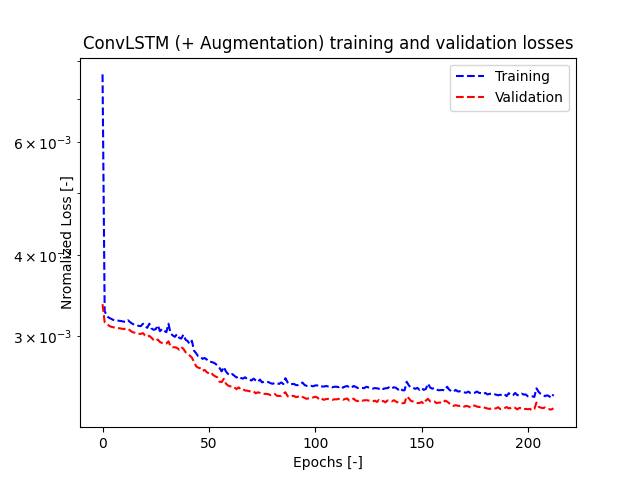

In [22]:
plot_losses(train_losses, val_losses, 'ConvLSTM (+ Augmentation) ')

In [ ]:
plot_animation(10, normalized_train_dataset, model, train_val,
               scaler_x, scaler_wd, scaler_q, device = device, save = False)